<a href="https://colab.research.google.com/github/Shatrughna-Chaurasia/Analysis-of-Interval-censored-data-with-weibull-lifetime-distribution/blob/main/ipynbs/RiskSensitive_AC_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [1]:
! pip install setuptools==65.5.0
! pip install -q stable_baselines3
! pip install -q PyPortfolioOpt
! pip install -q yahoo-finance
! pip install -q yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/363.4 MB 153.3 MB/s eta 0:00:02^C
^C
^C
^C


In [ ]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install setuptools==65.5.0
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 46.2 MB/s eta 0:00:00
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-llaf3ar5
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-llaf3ar5
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 69776b349ee4e63efe3826f318aef8e5c5f59648
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-r_k4ezgv/elegantrl_65c56843811e4192b9be918145e72c85
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-r_k4ezgv/elegantrl_65c56843811e4192b9be918145e72c85
  Resolved https://github.com/AI4Finance-Foundation/Eleg

In [ ]:
!pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.0/123.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 17.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.11/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.11/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [ ]:
import sys
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import copy
from typing import Any, Dict, List, Optional, Tuple, Type, TypeVar, Union
import torch as th
from torch.nn import functional as F
from stable_baselines3 import PPO,SAC
from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.noise import ActionNoise
from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import get_parameters_by_name, polyak_update
from stable_baselines3.sac.policies import CnnPolicy, MlpPolicy, MultiInputPolicy, SACPolicy
import yfinance as yf
from itertools import count
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pandas_datareader import data as pdr
import numpy as np
import random
import math
import time
import gym
from gym.utils import seeding
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import objective_functions
from pypfopt.efficient_frontier import EfficientFrontier
import torch
from collections import namedtuple, deque
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

In [ ]:
# tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "JPM", "BAC", "V", "JNJ"]

# # start_date = '2013-06-04'
# # end_date = "2022-11-20"
# df = yf.download(tickers, interval="60m", period="730d")
# df = df.dropna(axis=0)
# data = df.copy()
# data = data['Adj Close']
# data.shape

# train_pct = 1
# samples_train = int(train_pct*len(data))
# # print(len(data))
# data_train = data[:samples_train]
# data_test = data[samples_train:]

# plt.rcParams["figure.figsize"] = (10, 6)
# for i in tickers:
#     plt.plot(data[i], label=i)
# # only one line may be specified; full height
# plt.legend()
# plt.margins(x=0)
# plt.ylabel("Closing Share Prise (USD)")
# plt.xlabel("Time")
# plt.savefig('StockPrice.png', bbox_inches='tight')

In [ ]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-03-01'

In [ ]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (97013, 8)


In [ ]:
# import datetime as dt
# start_date = dt.datetime.now() - dt.timedelta(days=30) # Set start date to
# end_date = dt.datetime.now() # Set end date to today

# date_range = pd.date_range(start_date, end_date, freq='7d') # Split the date range into 7-day intervals

# dataframes = [] # List to store dataframes for each interval

# for i in range(len(date_range)-1):
#     interval_start = date_range[i]
#     interval_end = date_range[i+1]

#     df = yf.download(tickers=config_tickers.DOW_30_TICKER, interval='1m', start=interval_start, end=interval_end)
#     dataframes.append(df)

# # Concatenate the dataframes
# full_df = pd.concat(dataframes)

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2010-01-04,6.440331,7.660714,7.585000,7.622500,493729600,AAPL,0
1,2010-01-04,40.265976,57.869999,56.560001,56.630001,5277400,AMGN,0
2,2010-01-04,32.720379,41.099998,40.389999,40.810001,6894300,AXP,0
3,2010-01-04,43.777557,56.389999,54.799999,55.720001,6186700,BA,0
4,2010-01-04,39.547810,59.189999,57.509998,57.650002,7325600,CAT,0


## Preprocess

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3310, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [ ]:
len(processed),len(processed_full),len(df)

(95990, 95990, 97013)

In [ ]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

85753
10237


In [ ]:
train.tail()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2956,2021-09-30,UNH,371.414154,403.489990,390.459991,401.489990,3779900.0,3.0,-4.215702,406.339777,374.984613,40.895416,-222.645168,41.980385,393.482301,392.988887,23.139999,24.872099
2956,2021-09-30,V,216.924591,228.789993,222.630005,227.580002,7128500.0,3.0,-1.515438,225.179239,213.252815,44.079011,-54.448778,19.569853,221.375694,227.976406,23.139999,24.872099
2956,2021-09-30,VZ,42.742085,54.509998,54.000000,54.500000,18736600.0,3.0,-0.203777,43.718476,42.508790,41.824956,-101.984676,21.682953,43.259641,43.717979,23.139999,24.872099
2956,2021-09-30,WBA,38.408340,48.930000,46.919998,48.790001,6449400.0,3.0,-0.221533,42.405394,38.093749,44.613740,-106.145276,0.941150,40.094060,39.195162,23.139999,24.872099
2956,2021-09-30,WMT,44.220192,47.243332,46.416668,46.880001,22457700.0,3.0,-0.505126,47.482041,44.063715,40.165851,-151.472370,45.479205,46.244332,45.887431,23.139999,24.872099


In [ ]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,139.992508,142.919998,139.110001,141.899994,94639600.0,4.0,-1.686475,153.831495,135.763059,46.927759,-142.249020,41.749873,145.702427,144.809052,21.1,120.122752
0,2021-10-01,AMGN,191.379211,214.610001,210.800003,213.589996,2629400.0,4.0,-2.907905,199.755661,187.186061,40.408579,-97.158043,36.189244,195.730696,203.825874,21.1,120.122752
0,2021-10-01,AXP,165.851654,175.119995,168.479996,168.500000,3956000.0,4.0,2.217004,169.902263,145.535350,56.265095,117.355356,15.667511,157.221237,159.408883,21.1,120.122752
0,2021-10-01,BA,226.000000,226.720001,220.600006,222.850006,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.122752
0,2021-10-01,CAT,180.580688,195.869995,191.240005,192.899994,3695500.0,4.0,-3.497999,197.692323,174.339356,41.999448,-112.225019,36.203176,189.292059,192.682355,21.1,120.122752


In [ ]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [ ]:
train

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,6.440331,7.660714,7.585000,7.622500,493729600.0,0.0,0.000000,6.461646,6.430151,100.000000,66.666667,100.000000,6.440331,6.440331,20.040001,0.000000
0,2010-01-04,AMGN,40.265976,57.869999,56.560001,56.630001,5277400.0,0.0,0.000000,6.461646,6.430151,100.000000,66.666667,100.000000,40.265976,40.265976,20.040001,0.000000
0,2010-01-04,AXP,32.720379,41.099998,40.389999,40.810001,6894300.0,0.0,0.000000,6.461646,6.430151,100.000000,66.666667,100.000000,32.720379,32.720379,20.040001,0.000000
0,2010-01-04,BA,43.777557,56.389999,54.799999,55.720001,6186700.0,0.0,0.000000,6.461646,6.430151,100.000000,66.666667,100.000000,43.777557,43.777557,20.040001,0.000000
0,2010-01-04,CAT,39.547810,59.189999,57.509998,57.650002,7325600.0,0.0,0.000000,6.461646,6.430151,100.000000,66.666667,100.000000,39.547810,39.547810,20.040001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2956,2021-09-30,UNH,371.414154,403.489990,390.459991,401.489990,3779900.0,3.0,-4.215702,406.339777,374.984613,40.895416,-222.645168,41.980385,393.482301,392.988887,23.139999,24.872099
2956,2021-09-30,V,216.924591,228.789993,222.630005,227.580002,7128500.0,3.0,-1.515438,225.179239,213.252815,44.079011,-54.448778,19.569853,221.375694,227.976406,23.139999,24.872099
2956,2021-09-30,VZ,42.742085,54.509998,54.000000,54.500000,18736600.0,3.0,-0.203777,43.718476,42.508790,41.824956,-101.984676,21.682953,43.259641,43.717979,23.139999,24.872099
2956,2021-09-30,WBA,38.408340,48.930000,46.919998,48.790001,6449400.0,3.0,-0.221533,42.405394,38.093749,44.613740,-106.145276,0.941150,40.094060,39.195162,23.139999,24.872099


# Environment

In [ ]:
max_trade = 50
balance = 10000
transaction_fee = 0.001

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class StockEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, df, tickers):
        self.df = df
        self.tickers = tickers
        self.stock_dim = self.df.shape[1]
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.stock_dim,))
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(2*self.stock_dim+1,))
        self.data = self.df.iloc[0, :]
        self.state = [balance]+self.data.values.tolist()+[0]*self.stock_dim
        self.reward = 0
        self.memory = [balance]
        self.terminal = False
        self.day = 0
        self.sharpe = 0
        self.beta = 0
        self.act_memory = [[1/self.stock_dim]*self.stock_dim]
        self.assets = []

    def sell(self, index, action):
        action = np.floor(action)
        if self.state[index+self.stock_dim+1] > 0:
            self.state[0] += self.state[index+1] * \
                min(abs(action),
                    self.state[index+self.stock_dim+1]) * (1 - transaction_fee)
            self.state[index+self.stock_dim +
                       1] -= min(abs(action), self.state[index+self.stock_dim+1])

    def buy(self, index, action):
        action = np.floor(action)
        max_action = min(
            self.state[0]//(self.state[index+1] * (1 + transaction_fee)), action)
        self.state[0] -= self.state[index+1] * \
            max_action * (1 + transaction_fee)
        self.state[index+self.stock_dim+1] += max_action

    def step(self, actions):
        self.terminal = (self.day >= len(self.df.index.unique())-1)
        if self.terminal:
            return self.state, self.reward, self.terminal, {}

        else:
            actions = actions*max_trade

            total_assets = self.state[0]
            total_assets += sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(
                self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            args = np.argsort(actions)
            sell_index = args[:np.where(actions < 0)[0].shape[0]]
            buy_index = args[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                self.sell(index, actions[index])

            for index in buy_index:
                self.buy(index, actions[index])

            # force buy with balance (equal weight to stocks)
            if(self.state[0] > 0):
                cash_div = self.state[0]/self.stock_dim
                for i in range(self.stock_dim):
                    autoaction = cash_div//(self.state[i+1]
                                            * (1 + transaction_fee))
                    self.buy(i, autoaction)

            self.day += 1
            self.data = self.df.iloc[self.day, :]

            self.state = [self.state[0]]+self.data.values.tolist() + \
                list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)])

            final_assets = self.state[0]
            final_assets += sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(
                self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            weights = self.normalize(
                np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            # if self.day >= 10:
            #     self.sharpe = self.get_sharpe(
            #         self.df.iloc[:self.day, :], weights)

            self.reward = self.beta*(self.sharpe) + \
                (1-self.beta)*(final_assets - total_assets)/1000
            self.act_memory.append(weights.tolist())
            self.assets.append(final_assets)
        return self.state, self.reward, self.terminal, {}

    def normalize(self, actions):
        return actions/(np.sum(actions)+1e-10)

    def get_sharpe(self, data, weights):
        mu = mean_historical_return(data)
        S = CovarianceShrinkage(data).ledoit_wolf()
        ef = EfficientFrontier(mu, S)
        ef.set_weights({self.tickers[i]: weights[i]
                       for i in range(len(self.tickers))})
        return (ef.portfolio_performance()[2])

    def render(self, mode='human', close=False):
        return self.state

    def reset(self):
        self.day = 0
        self.data = self.df.iloc[0, :]
        self.terminal = False
        self.act_memory = [[1/self.stock_dim]*self.stock_dim]
        self.assets = []
        self.state = [balance]+self.data.values.tolist()+[0]*self.stock_dim
        self.reward = 0
        return self.state

    def get_action_memory(self):
        return (self.act_memory,self.assets)


# Agent

In [ ]:
class Actor(nn.Module):
  def __init__(self,state_dim,n_actions):
    super().__init__()
    self.n_actions = n_actions
    self.mu = nn.Sequential(
        nn.Linear(state_dim,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,n_actions),
        nn.Tanh(),
    )
    self.std = nn.Sequential(
        nn.Linear(state_dim,n_actions),
        nn.Softplus(),
    )
    self.LOG_STD_MAX = 2
    self.LOG_STD_MIN = -20

  def forward(self,x):
    mu = self.mu(x)
    log_std = self.std(x)
    log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
    return mu,torch.exp(log_std)

  def get_dist(self,x):
    mean,std = self.forward(x)
    dist = torch.distributions.normal.Normal(mean, std)
    return dist

  def get_action(self,x):
    dist = self.get_dist(x)
    act = dist.rsample()
    return torch.tanh(act),dist.log_prob(act).sum(axis=1, keepdim=True)

In [ ]:
state = torch.rand(256,21)
action = torch.rand(256,10)
torch.cat((state,action),dim=1).shape

torch.Size([256, 31])

In [ ]:
# RAC.actor(torch.randn(256,1,21).to(device))[1].sum(axis=2,keepdim=True).shape

In [ ]:
class Critic(nn.Module):
  def __init__(self,state_dim,action_dim):
    super().__init__()
    self.q = nn.Sequential(
        nn.Linear(state_dim+action_dim,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,1),
    )

  def forward(self,s,a):
    inp = torch.cat((s,a),dim=1).to(device)
    return self.q(inp)

In [ ]:
# Risk Sensitive Actor Critic
class RiskAC(object):
  def __init__(self,state_dim,action_dim,max_action,ref_state,ref_action,discount=0.99,tau=0.005,lr=1e-4,alpha=1.0):
    self.actor = Actor(state_dim,action_dim).to(device)
    self.critic = Critic(state_dim,action_dim).to(device)
    self.actor_target = Actor(state_dim,action_dim).to(device)
    self.critic_target = copy.deepcopy(self.critic).to(device)
    self.actor_opt =  optim.Adam(self.actor.parameters(),lr=lr)
    self.critic_opt = optim.Adam(self.critic.parameters(),lr=lr)

    self.ref_state = torch.tensor(ref_state,device=device).reshape(1,-1)
    self.ref_action = torch.tensor(ref_action,device=device).reshape(1,-1)
    self.discount = discount
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.tau = tau
    self.alpha = alpha
    self.gamma = discount

  # Training
  def train(self,replay_buffer,batch_size=256):
    transitions = replay_buffer.sample(batch_size)
    batch = Transition(*zip(*transitions))
    state = torch.cat(batch.state).to(device).reshape(-1,self.state_dim)
    action = torch.cat(batch.action).to(device).reshape(-1,self.action_dim)
    next_state = torch.cat(batch.next_state).to(device).reshape(-1,self.state_dim)
    reward = torch.cat(batch.reward).to(device).reshape(-1,1)

    with torch.no_grad():
      next_action,next_log_prob = self.actor.get_action(next_state)
      target_q = self.critic_target(next_state,next_action)
      cur_q = self.critic_target(state,action)
      ref_q = self.critic_target(self.ref_state,self.ref_action)
      target_q = torch.div(target_q,(ref_q+1e-9))
      target_q = torch.exp(-reward)*target_q
      target_q = (target_q - self.alpha * next_log_prob)

    current_q = self.critic(state,action)
    q_loss = F.mse_loss(target_q,current_q)
    self.critic_opt.zero_grad()
    q_loss.backward()
    self.critic_opt.step()

    for params in self.critic.parameters():
      params.requires_grad = 	False

    a, log_pi_a = self.actor(state)
    q = self.critic(state, a)

    a_loss = (self.alpha * log_pi_a - q).mean()
    self.actor_opt.zero_grad()
    a_loss.backward()
    self.actor_opt.step()

    for params in self.critic.parameters():
      params.requires_grad = 	True

    # Soft Update
    for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
      target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

  def save(self, checkpoint_path):
      if not os.path.exists(os.path.dirname(checkpoint_path)):
          os.makedirs(os.path.dirname(checkpoint_path))

      state = {
          'actor': self.actor.state_dict(),
          'critic': self.critic.state_dict(),
          'actor_target': self.actor_target.state_dict(),
          'critic_target': self.critic_target.state_dict(),
          'actor_opt': self.actor_opt.state_dict(),
          'critic_opt': self.critic_opt.state_dict(),
          'ref_state': self.ref_state,
          'ref_action': self.ref_action,
          'discount': self.discount,
          'state_dim': self.state_dim,
          'action_dim': self.action_dim,
          'tau': self.tau,
          'alpha': self.alpha,
          'gamma': self.gamma
      }

      torch.save(state, checkpoint_path)

  def load(self, checkpoint_path):
      state = torch.load(checkpoint_path)

      self.actor.load_state_dict(state['actor'])
      self.critic.load_state_dict(state['critic'])
      self.actor_target.load_state_dict(state['actor_target'])
      self.critic_target.load_state_dict(state['critic_target'])
      self.actor_opt.load_state_dict(state['actor_opt'])
      self.critic_opt.load_state_dict(state['critic_opt'])
      self.ref_state = state['ref_state']
      self.ref_action = state['ref_action']
      self.discount = state['discount']
      self.state_dim = state['state_dim']
      self.action_dim = state['action_dim']
      self.tau = state['tau']
      self.alpha = state['alpha']
      self.gamma = state['gamma']

In [ ]:
def select_action(actor,state):
  with torch.no_grad():
    state = state.reshape(1, -1).clone().detach().to(device)
    a,_ = actor.get_action(state)
  return a.cpu().numpy().flatten().reshape(1,-1)

# Train


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "model_name" : "RSAC",
    "mode" : "train",
    "print_verbosity" : 1
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [ ]:
if torch.cuda.is_available():
    num_episodes = 20
else:
    num_episodes = 5

env =  StockTradingEnv(df = train, **env_kwargs)

In [ ]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [ ]:
%cd /content

/content


In [ ]:
memory = ReplayMemory(50000)
episodes = []
episodes_assets = []
BATCH_SIZE=1024
ref_state = env.observation_space.sample()
ref_action = env.action_space.sample()
RAC = RiskAC(state_dim=env.observation_space.shape[0],
               action_dim=env.action_space.shape[0],
               max_action=1,
               ref_state=ref_state,
               ref_action=ref_action
            )
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    # state = env.reset()
    reset_result = env.reset()
    state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    last_asset = []
    last_act = []
    last_state = []
    for t in count():
        action = select_action(RAC.actor,state)
        observation, reward, terminated, truncated, info = env.step(action.reshape(-1))

        done = terminated or truncated
        reward = torch.tensor([reward], device=device)
        if terminated:
            next_state = None
            episodes.append(last_act)
            episodes_assets.append(last_asset)
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state.float(), torch.tensor(np.array([action]),device=device).float(), next_state.float(), reward.float())

            # Move to the next state
            state = next_state
            last_act = env.actions_memory
            last_asset = env.asset_memory
            last_state = env.state_memory
            #last_episode, last_asset  = env.env_method(method_name="get_action_memory")[0]


        # Perform one step of the optimization (on the policy network)
        if len(memory) >= BATCH_SIZE:
          RAC.train(memory)

        if(done):
          break

print('Complete')

day: 2956, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 4607329.31
total_reward: 3607329.31
total_cost: 119018.96
total_trades: 53967
Sharpe: 0.859
day: 2956, episode: 6
begin_total_asset: 1000000.00
end_total_asset: 4281594.50
total_reward: 3281594.50
total_cost: 45861.17
total_trades: 43691
Sharpe: 0.857
day: 2956, episode: 7
begin_total_asset: 1000000.00
end_total_asset: 4299297.62
total_reward: 3299297.62
total_cost: 41654.26
total_trades: 41442
Sharpe: 0.867
day: 2956, episode: 8
begin_total_asset: 1000000.00
end_total_asset: 4335551.58
total_reward: 3335551.58
total_cost: 39323.07
total_trades: 41402
Sharpe: 0.874
day: 2956, episode: 9
begin_total_asset: 1000000.00
end_total_asset: 4702681.30
total_reward: 3702681.30
total_cost: 41007.01
total_trades: 41381
Sharpe: 0.879
day: 2956, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 4907049.19
total_reward: 3907049.19
total_cost: 41104.92
total_trades: 41548
Sharpe: 0.909
day: 2956, episode: 11
begin_total_ass

In [ ]:
RAC.save('./RAC_20.pth')

In [ ]:
RAC.load('./RAC_20.pth')

In [ ]:
tickers = train.tic.unique()

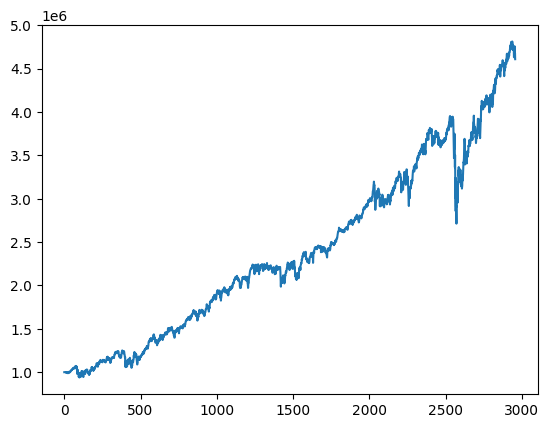

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(episodes_assets[0])
plt.show()

In [ ]:
np.array(last_state).shape

(59121, 291)

In [ ]:
num_episodes = 20

In [ ]:
data_train = pd.DataFrame(np.array(last_state)[:2956,1:len(tickers)+1],columns=tickers)

In [ ]:
weights = np.array(last_state)[:20*2956,len(tickers)+1:2*len(tickers)+1].reshape(num_episodes,2956,-1).astype(float)

In [ ]:
weights.shape

(20, 2956, 29)

In [ ]:
from scipy.special import softmax

In [ ]:
for i in range(weights.shape[0]):
  for j in range(weights.shape[1]):
    weights[i,j,:] = softmax(weights[i,j,:]/1075)

In [ ]:
np.mean(weights)

np.float64(0.034482758620689655)

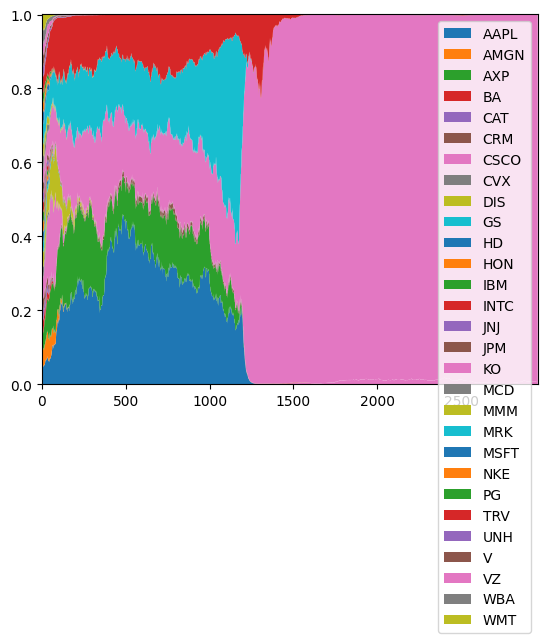

In [ ]:
df1 = pd.DataFrame(weights[0],
                      index=data_train.index, columns=tickers)
stock_dat = ()
for t in tickers:
    stock_dat += (df1[t],)
plt.stackplot(data_train.index, stock_dat, labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)

In [ ]:
# plotting the results
def plot(weights, cumulative, data_test):
    fig, axs = plt.subplots(2, 2, figsize=(20, 15), constrained_layout=True)

    ppo_mean = np.mean(np.array(cumulative), axis=0)
    ppo_std = np.std(np.array(cumulative), axis=0)

    axs[0, 0].plot(data_test.index, ppo_mean, color='tab:blue', linewidth=2.0)
    axs[0, 0].fill_between(data_test.index, ppo_mean - ppo_std,
                           ppo_mean + ppo_std, alpha=0.2, color='tab:blue')
    axs[0, 0].margins(x=0)
    axs[0, 0].margins(y=0)
    axs[0, 0].set_ylim(0)
    axs[0, 0].axhline(1, color='black', linestyle='--', lw=2)
    axs[0, 0].set_ylabel("Cumulative Returns")
    axs[0, 0].set_xlabel("Time (Years-Months)")

    weights_ = np.mean(np.array(weights), axis=0)
    df = pd.DataFrame(weights_,
                      index=data_test.index, columns=tickers)
    stock_dat = ()
    for t in tickers:
        stock_dat += (df[t],)
    axs[0, 1].stackplot(data_test.index, stock_dat, labels=tickers)
    axs[0, 1].legend(loc='upper right')
    axs[0, 1].margins(x=0)
    axs[0, 1].margins(y=0)
    axs[0, 1].set_ylabel("Weights mean (%)")
    axs[0, 1].set_xlabel("Time (Years-Months)")

    weights_ = weights[np.argmax(
        cumulative[:, -1])]
    df = pd.DataFrame(weights_,
                      index=data_test.index, columns=tickers)
    stock_dat = ()
    for t in tickers:
        stock_dat += (df[t],)
    axs[1, 0].stackplot(data_test.index, stock_dat, labels=tickers)
    axs[1, 0].margins(x=0)
    axs[1, 0].margins(y=0)
    axs[1, 0].set_ylabel("Weights max(%)")
    axs[1, 0].set_xlabel("Time (Years-Months)")

    weights_ = weights[np.argmin(
        cumulative[:, -1])]
    df = pd.DataFrame(weights_,
                      index=data_test.index, columns=tickers)
    stock_dat = ()
    for t in tickers:
        stock_dat += (df[t],)
    axs[1, 1].stackplot(data_test.index, stock_dat, labels=tickers)
    axs[1, 1].margins(x=0)
    axs[1, 1].margins(y=0)
    axs[1, 1].set_ylabel("Weights min(%)")
    axs[1, 1].set_xlabel("Time (Years-Months)")

    plt.savefig('ppo.png', bbox_inches='tight')

In [ ]:
def get_cumulative(weights,data):
  return_stocks = data.pct_change()
  return_stocks_weights = np.sum(return_stocks.multiply(weights), axis=1)
  cumulative = (1+return_stocks_weights).cumprod()
  return cumulative

(20, 2956) (20, 2956, 29)


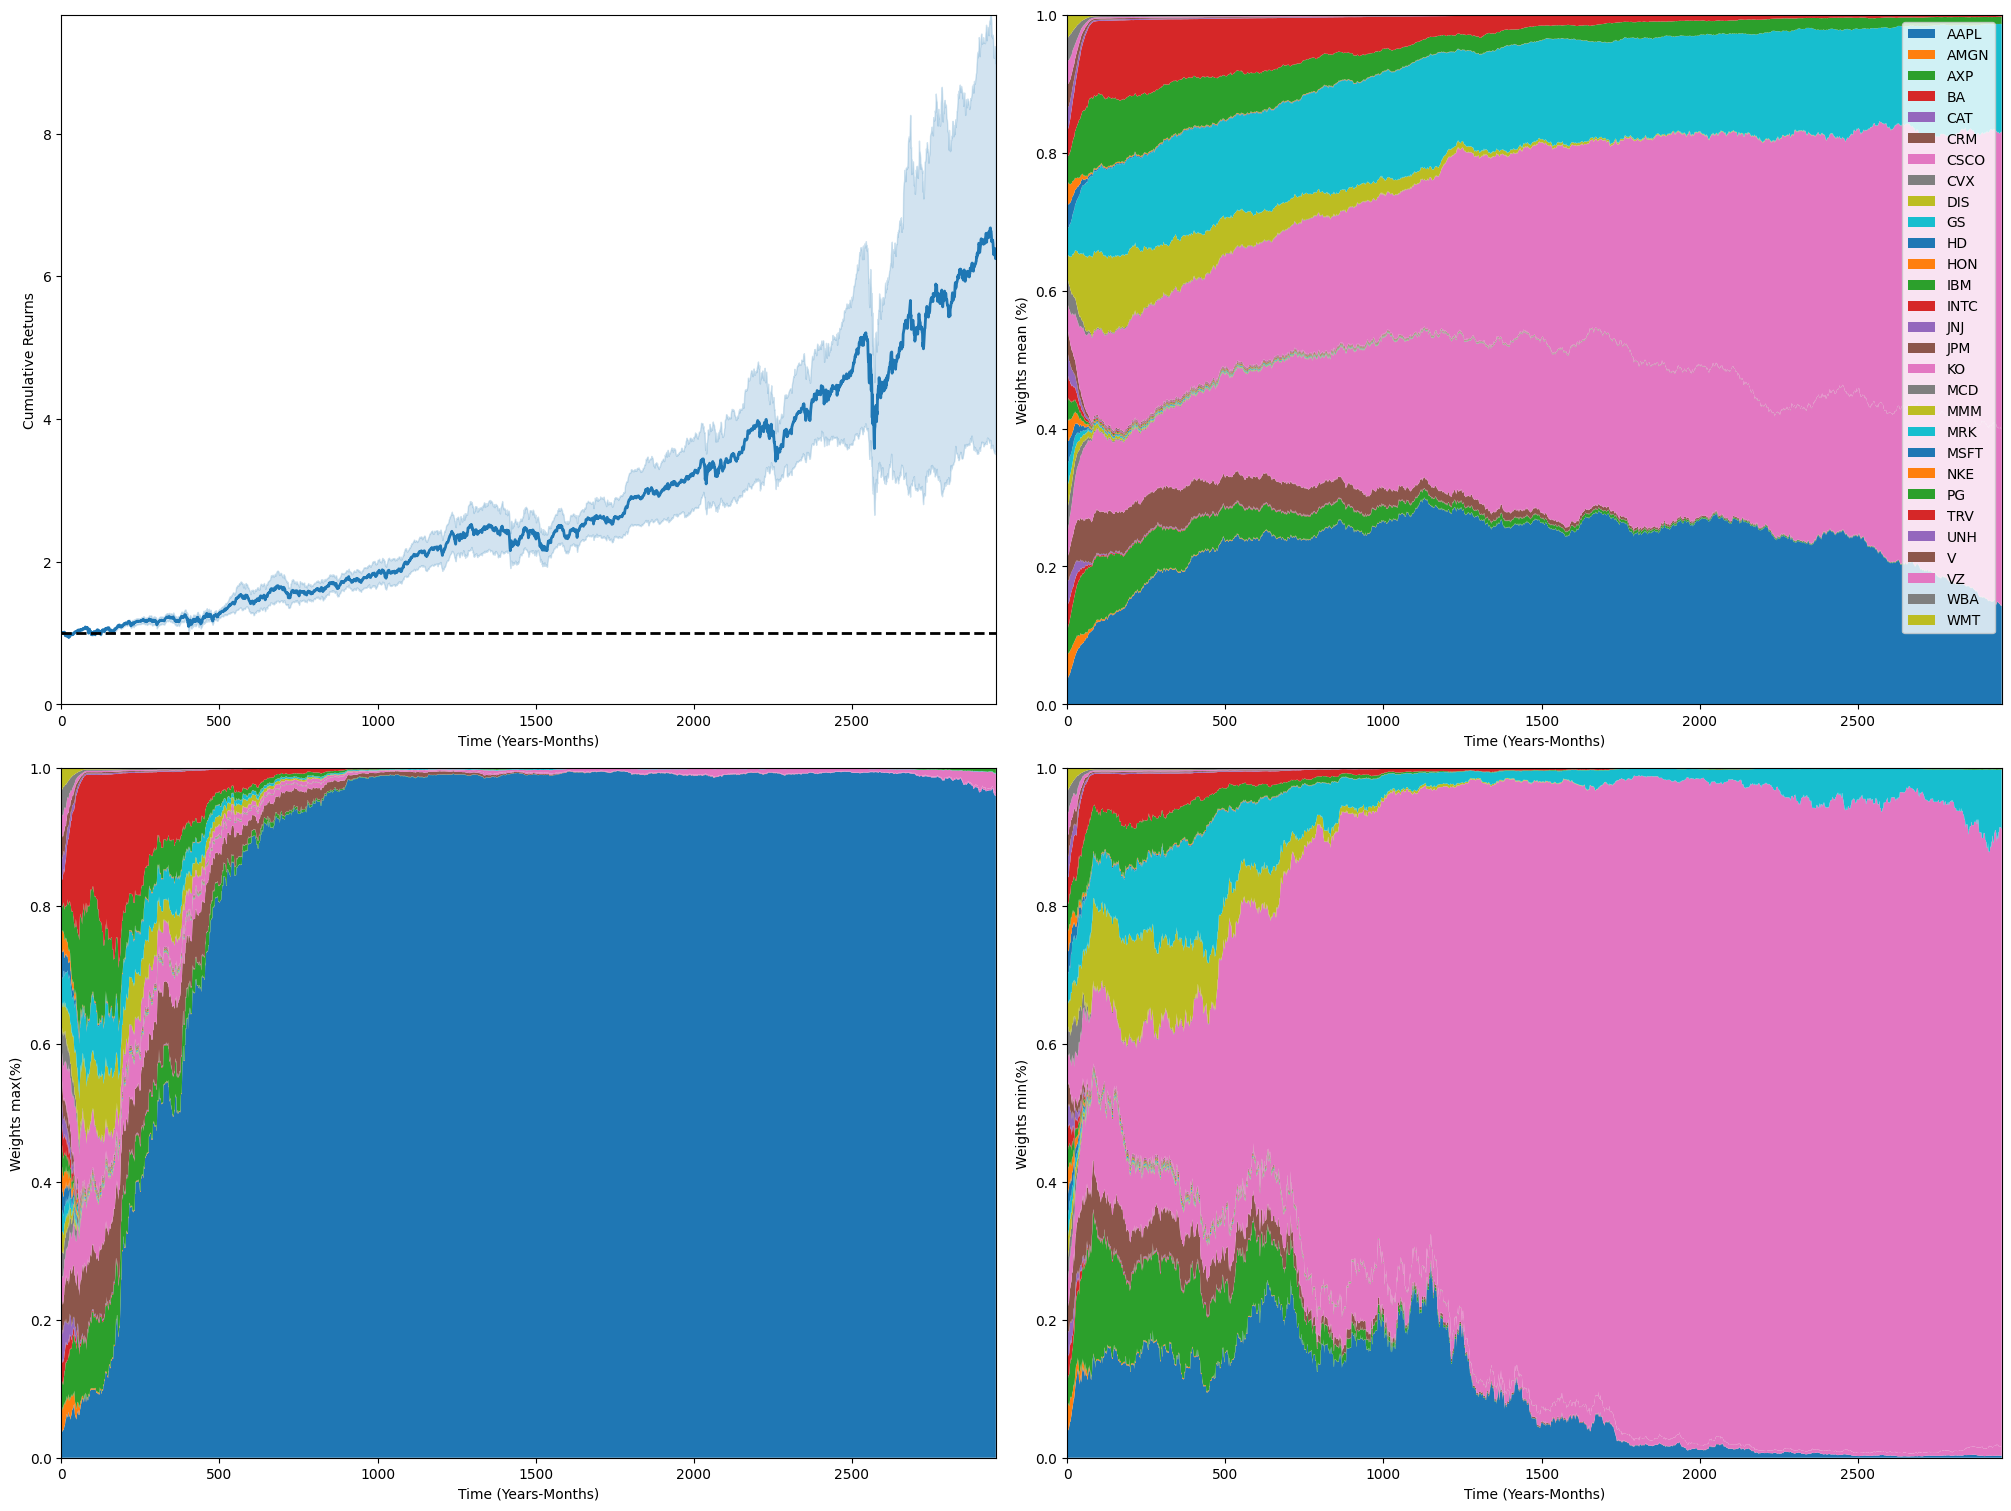

In [ ]:
runs = len(episodes)
cumulative = np.array([get_cumulative(weights[i],data_train) for i in range(len(weights))])
print(cumulative.shape,weights.shape)
plot(weights,cumulative,data_train)

(20, 2956) (20, 2956, 29)


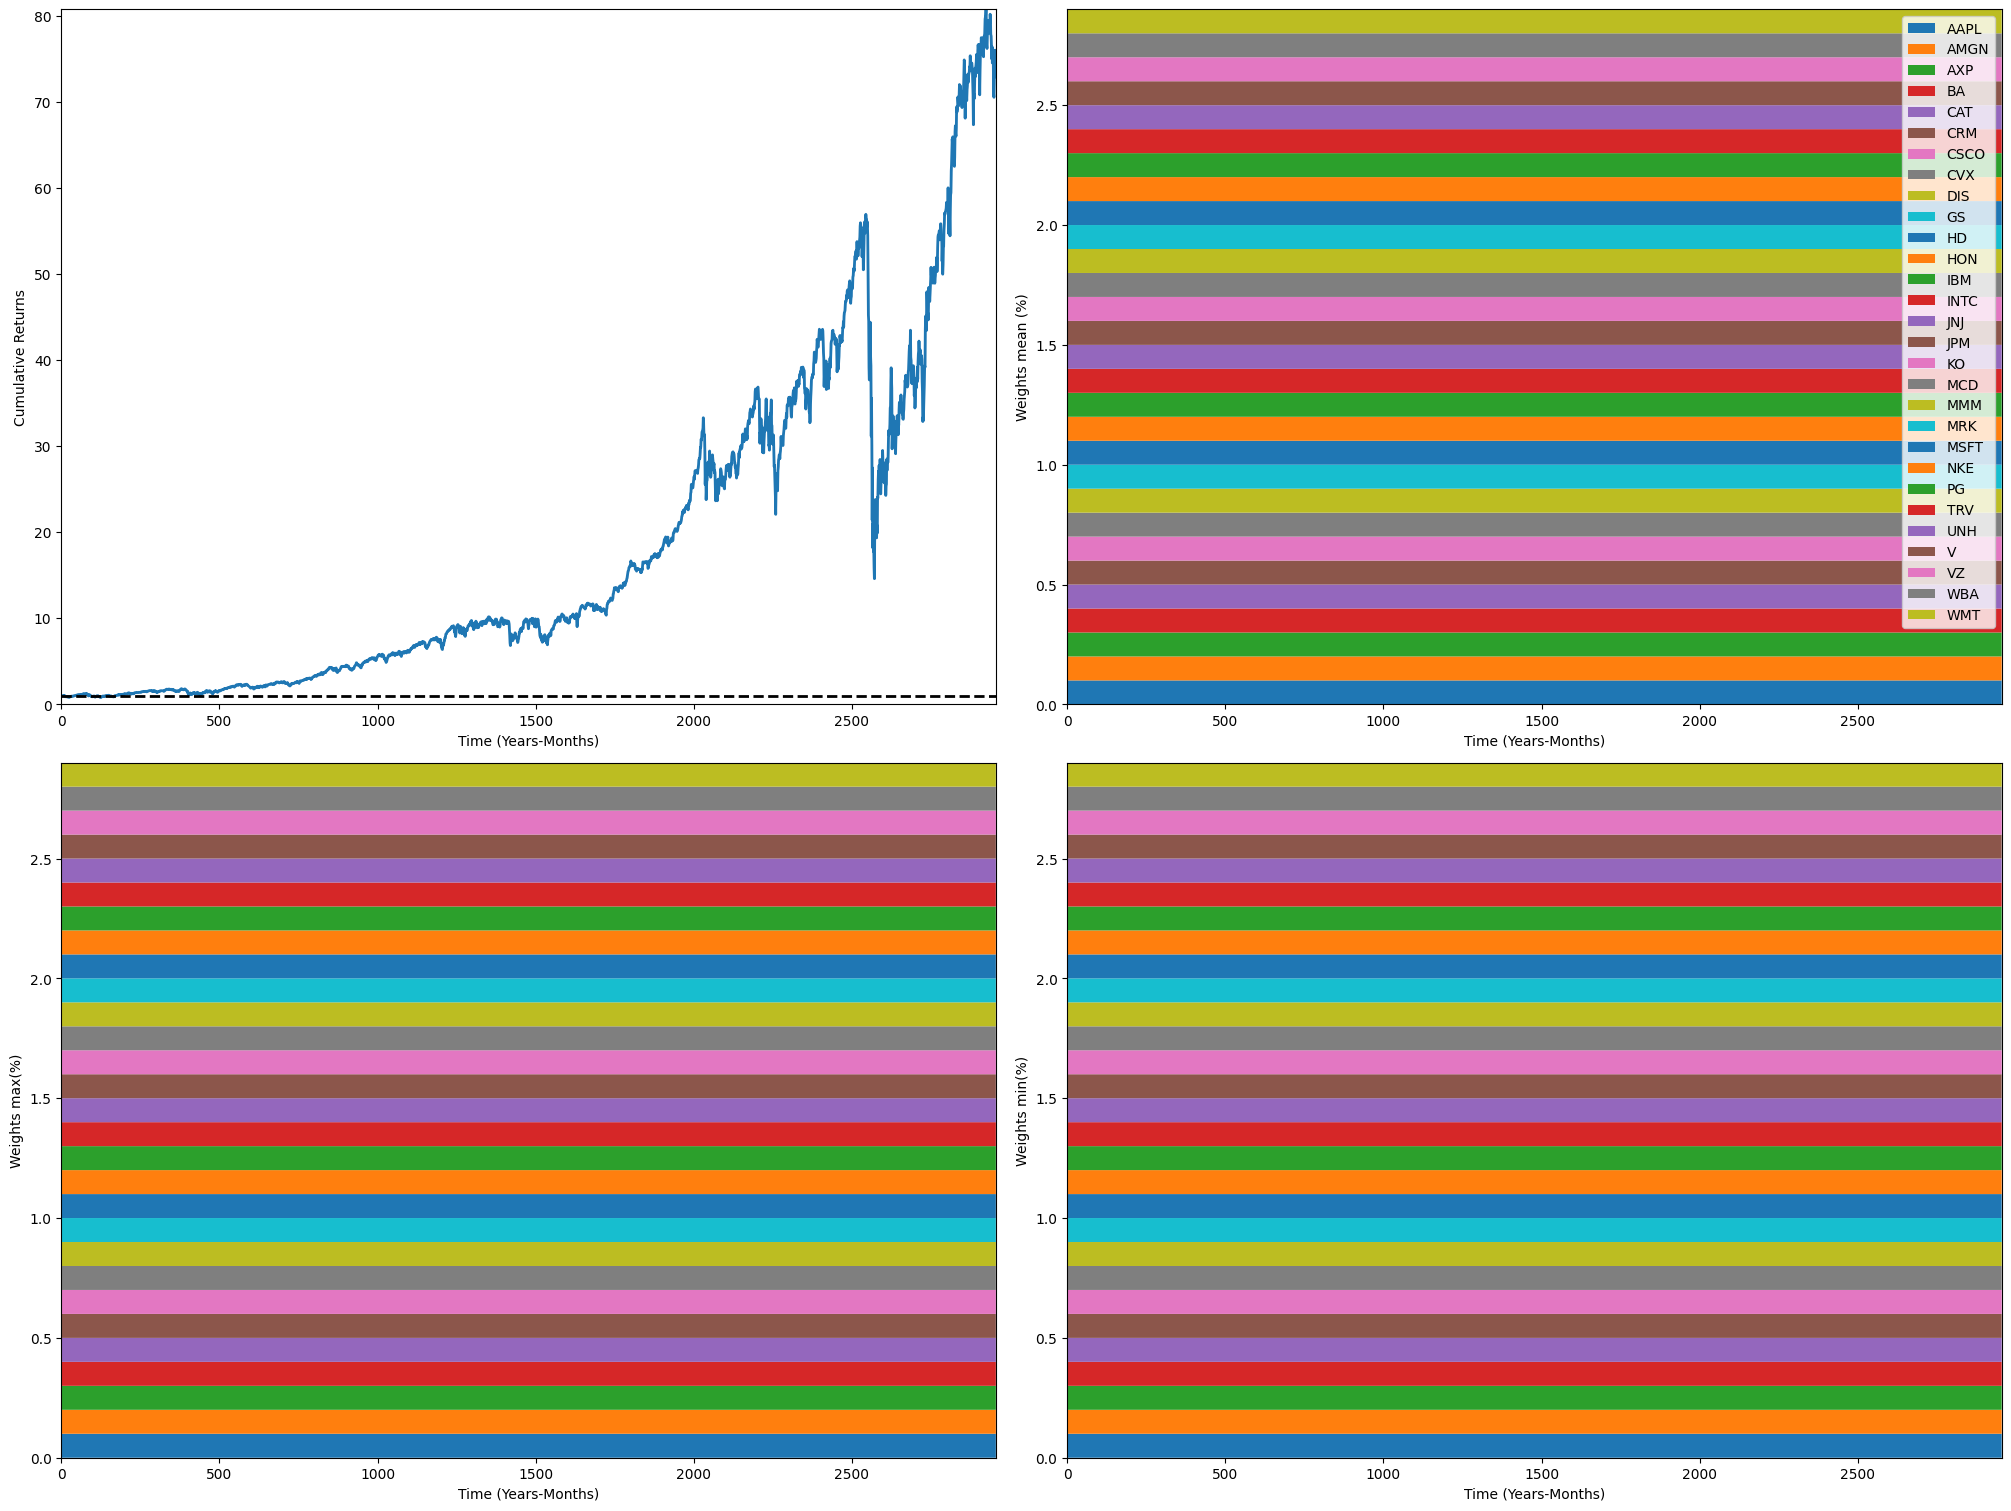

In [ ]:
weights.fill(0.1)
runs = len(episodes)
cumulative = np.array([get_cumulative(weights[i],data_train) for i in range(len(weights))])
print(cumulative.shape,weights.shape)
plot(weights,cumulative,data_train)

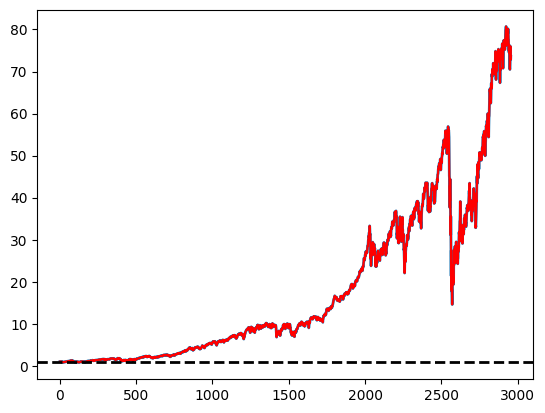

In [ ]:
mean = np.mean(np.array(cumulative), axis=0)
std = np.std(np.array(cumulative), axis=0)
plt.plot(data_train.index, mean, color='tab:blue', linewidth=2.0)
plt.fill_between(data_train.index, mean - std,
                           mean + std, alpha=0.2, color='tab:blue')
plt.plot(data_train.index,cumulative[0],c='r')
plt.axhline(1, color='black', linestyle='--', lw=2)

In [ ]:
np.array(episodes_assets).shape

(20, 2957)

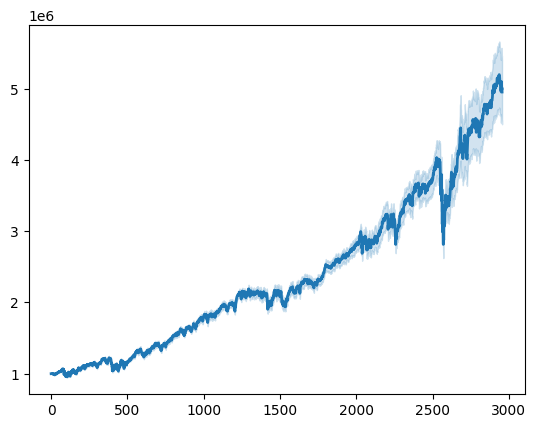

In [ ]:
mean = np.mean(np.array(episodes_assets)[:,1:], axis=0)
std = np.std(np.array(episodes_assets)[:,1:], axis=0)
plt.plot(data_train.index, mean, color='tab:blue', linewidth=2.0)
plt.fill_between(data_train.index, mean - std,
                           mean + std, alpha=0.2, color='tab:blue')

# BackTest

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [ ]:
def DRL_prediction(model, environment, deterministic=True):
      test_env, test_obs = environment.get_sb_env()
      """make a prediction"""
      account_memory = []
      actions_memory = []
      #         state_memory=[] #add memory pool to store states
      observation = test_env.reset()
      for i in range(len(environment.df.index.unique())):
          action = select_action(model.actor,torch.tensor(observation))
          # account_memory = test_env.env_method(method_name="save_asset_memory")
          # actions_memory = test_env.env_method(method_name="save_action_memory")
          observation, reward, terminated, _ = test_env.step(action)
          if i == (len(environment.df.index.unique()) - 2):
              account_memory = test_env.env_method(method_name="save_asset_memory")
              actions_memory = test_env.env_method(method_name="save_action_memory")
          #                 state_memory=test_env.env_method(method_name="save_state_memory") # add current state to state memory
          if terminated:
              print("hit end!")
              break
      return account_memory[0], actions_memory[0]

In [ ]:
trained_model = RAC
df_account_value_rac, df_actions_rac = DRL_prediction(
    model=trained_model,
    environment = e_trade_gym)

day: 352, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 997214.58
total_reward: -2785.42
total_cost: 8667.77
total_trades: 4615
Sharpe: 0.087
hit end!


In [ ]:
df_account_value_rac.to_csv('df_account_value_rac.csv')

In [ ]:
df_actions_rac.to_csv('df_actions_rac.csv')

In [ ]:
df_account_value_rac

,date,account_value
0,2021-10-01,1.000000e+06
1,2021-10-04,9.983853e+05
2,2021-10-05,1.000697e+06
3,2021-10-06,1.002451e+06
4,2021-10-07,1.005536e+06
...,...,...
348,2023-02-21,9.994600e+05
349,2023-02-22,1.001874e+06
350,2023-02-23,1.004551e+06
351,2023-02-24,9.960807e+05


In [ ]:
df_result_rac = df_account_value_rac.set_index(df_account_value_rac.columns[0])
df_account_value_rac.to_csv("df_account_value_rac.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_rac['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = df_result_rac

print("result: ", result)
result.to_csv("result.csv")

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (354, 8)
Annual return         -0.034876
Cumulative returns    -0.048644
Annual volatility      0.181612
Sharpe ratio          -0.105351
Calmar ratio          -0.158953
Stability              0.280983
Max drawdown          -0.219408
Omega ratio            0.982546
Sortino ratio         -0.146974
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970602
Daily value at risk   -0.022957
dtype: float64
result:              account_value
date                     
2021-10-01   1.000000e+06
2021-10-04   9.983853e+05
2021-10-05   1.000697e+06
2021-10-06   1.002451e+06
2021-10-07   1.005536e+06
...                   ...
2023-02-21   9.994600e+05
2023-02-22   1.001874e+06
2023-02-23   1.004551e+06
2023-02-24   9.960807e+05
2023-02-27   9.972146e+05

[353 rows x 1 columns]


<Figure size 1500x500 with 0 Axes>

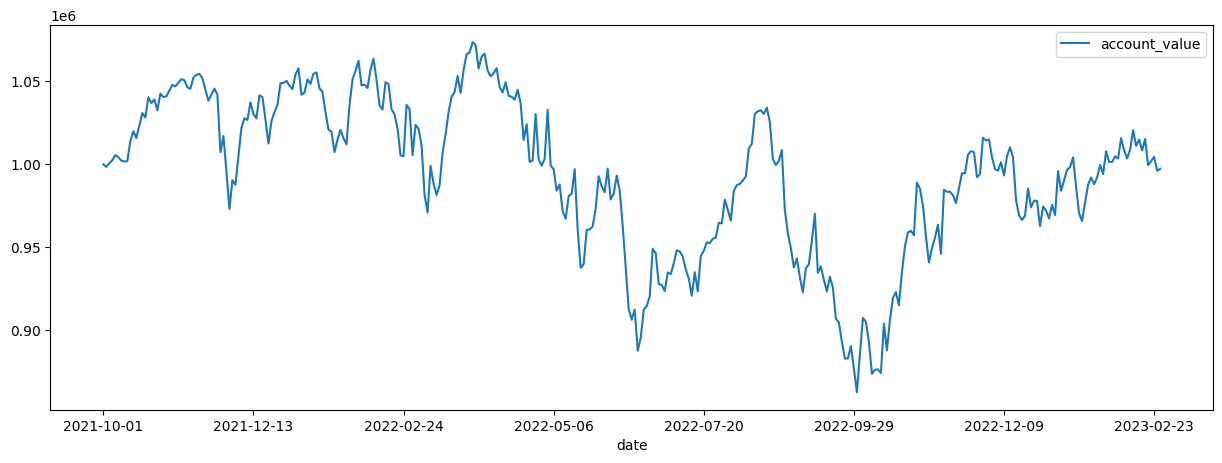

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

# Test

In [ ]:
!pip install yfinance

In [ ]:
import pyfolio as pf

In [ ]:
fb = yf.Ticker('AAPL')
history = fb.history('max')
history.index = history.index.tz_convert('UTC')

In [ ]:
returns = history.Close.pct_change()

In [ ]:
from finrl.plot import get_daily_return

In [ ]:
df_daily_return = get_daily_return(df_account_value_rac)

/usr/local/lib/python3.11/dist-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.199%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2021-10-01
End date,2023-02-27
Total months,16
,Backtest
Annual return,-0.199%
Cumulative returns,-0.279%
Annual volatility,19.479%
Sharpe ratio,0.09
Calmar ratio,-0.01
Stability,0.25
Max drawdown,-19.667%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.67,2022-03-29,2022-09-30,NaT,NaN
1,8.73,2022-02-09,2022-03-08,2022-03-25,33
2,7.72,2021-11-16,2021-12-01,2022-01-04,36
3,4.79,2022-01-04,2022-01-21,2022-02-02,22
4,1.54,2022-02-02,2022-02-07,2022-02-09,6


/usr/local/lib/python3.11/dist-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/usr/local/lib/python3.11/dist-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


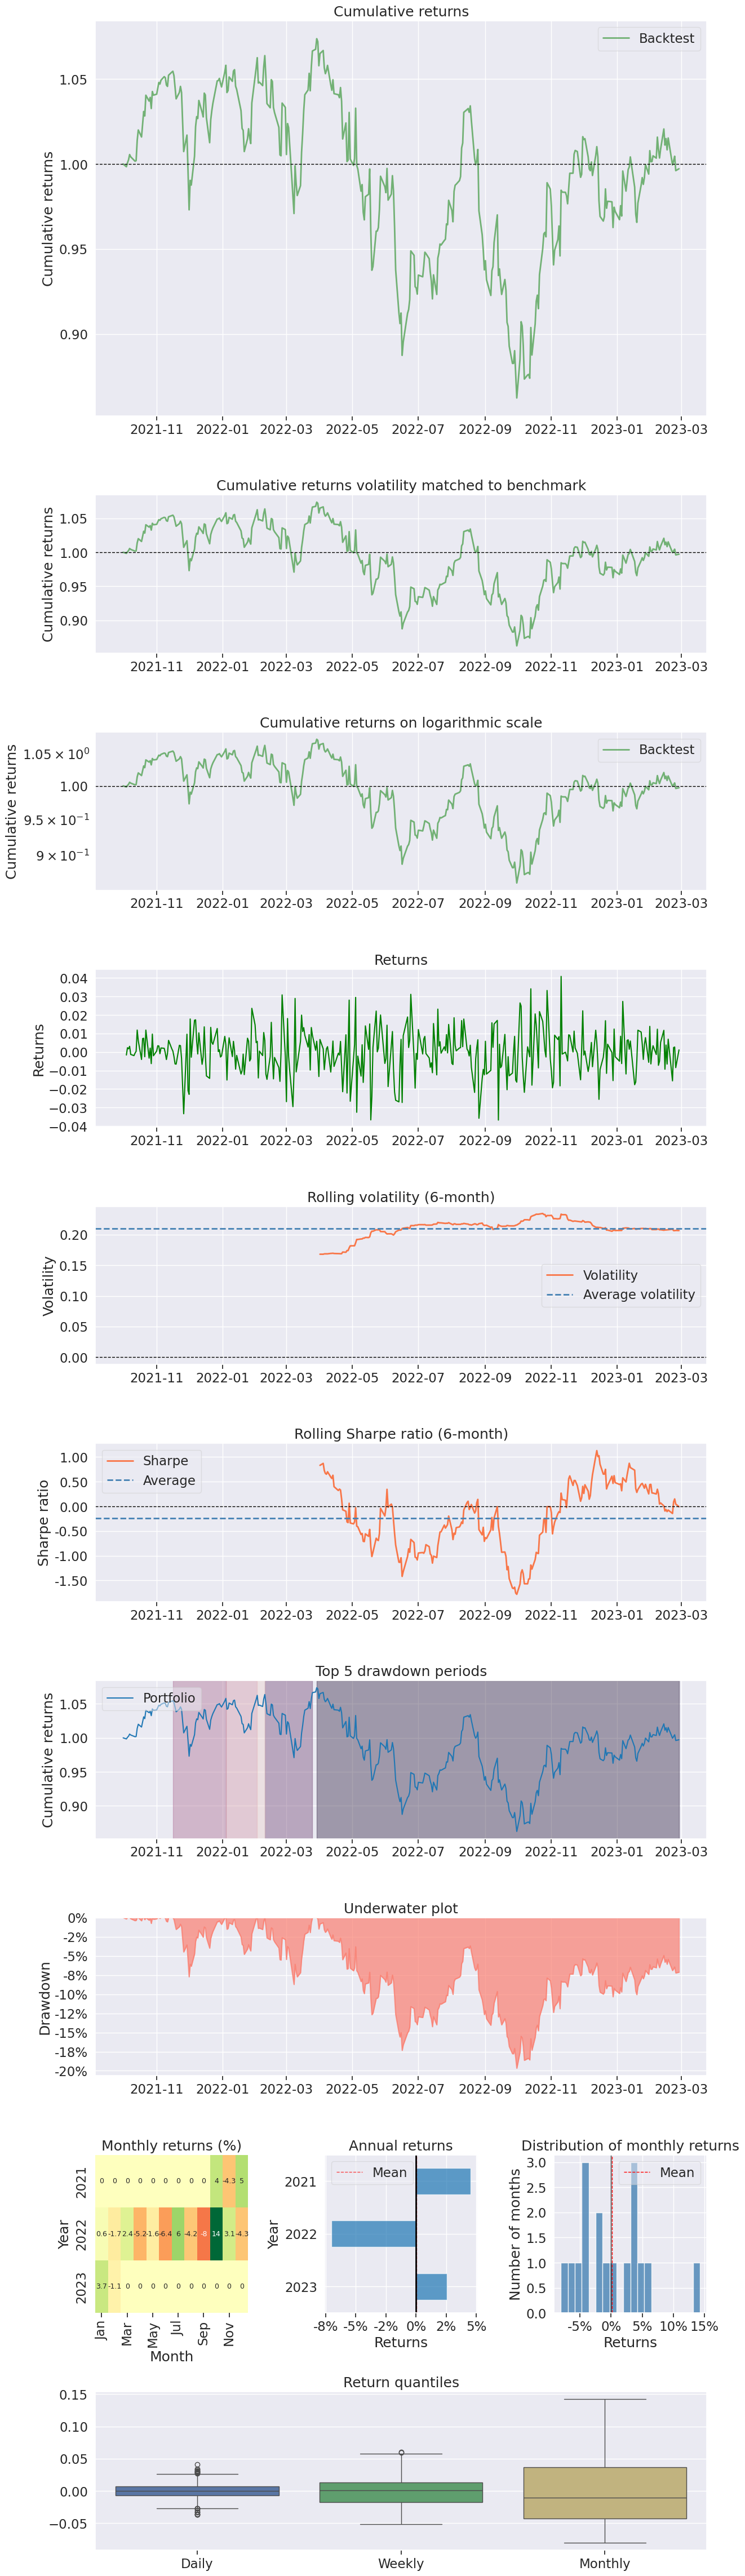

In [ ]:
pf.create_returns_tear_sheet(df_daily_return.squeeze())

/usr/local/lib/python3.11/dist-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.008%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2021-10-01
End date,2023-02-27
Total months,16
,Backtest
Annual return,-3.008%
Cumulative returns,-4.187%
Annual volatility,18.177%
Sharpe ratio,-0.08
Calmar ratio,-0.14
Stability,0.28
Max drawdown,-21.941%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.94,2022-01-04,2022-09-30,NaT,NaN
1,6.62,2021-11-08,2021-12-01,2021-12-29,38
2,1.09,2021-10-07,2021-10-13,2021-10-14,6
3,0.94,2021-10-01,2021-10-04,2021-10-06,4
4,0.74,2021-10-26,2021-10-27,2021-10-29,4


/usr/local/lib/python3.11/dist-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/usr/local/lib/python3.11/dist-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


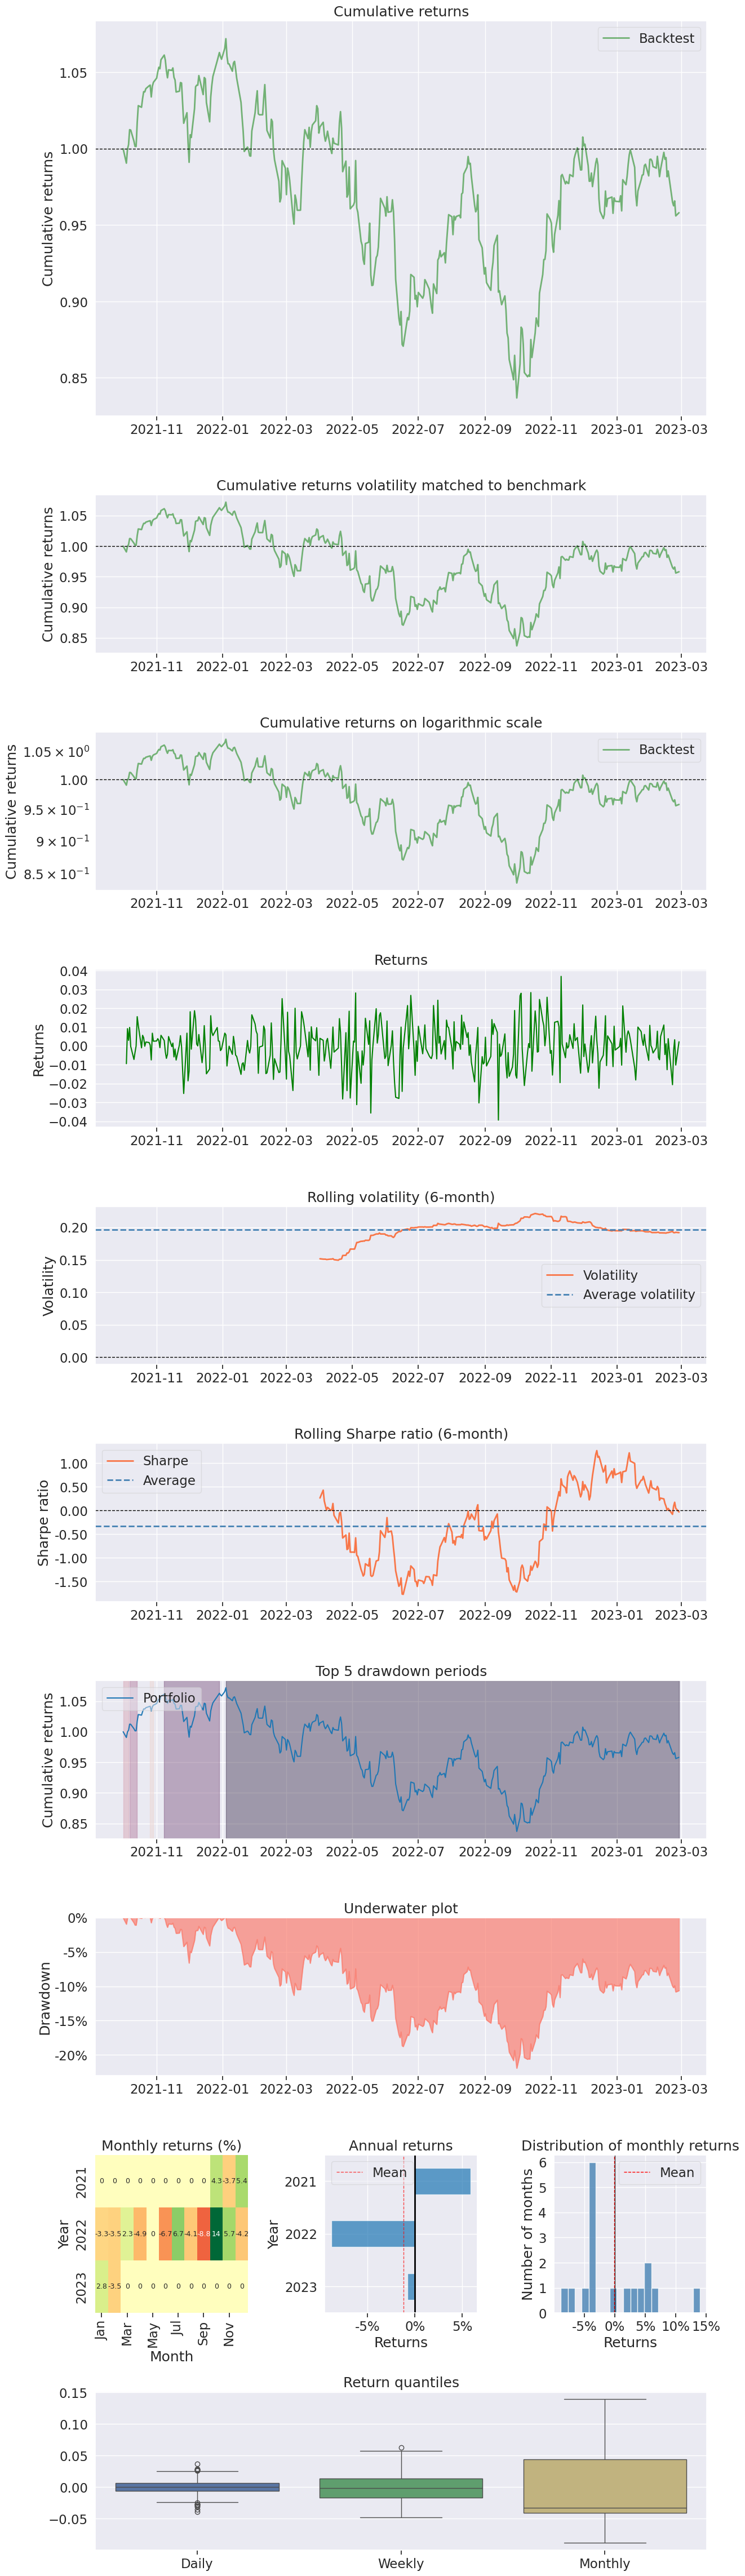

In [ ]:
pf.create_returns_tear_sheet(get_daily_return(df_dji.reset_index()).squeeze())


# Compare Agents

# Test

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
mean = 0
std = 1
normal_distributions = torch.distributions.normal.Normal(mean, std)
sample = normal_distributions.sample()
log_probs = normal_distributions.log_prob(torch.tensor([0,1,2,3]))
print(sample,log_probs)

tensor(-0.5605) tensor([-0.9189, -1.4189, -2.9189, -5.4189])


In [ ]:
normal_distributions

Normal(loc: 0.0, scale: 1.0)

In [ ]:
log_probs

tensor([-0.9189, -1.4189, -2.9189, -5.4189])

In [ ]:
b = spaces.Box(low=-1, high=1, shape=(10,))

In [ ]:
torch.tensor(b.sample())

tensor([ 0.5349,  0.6901, -0.1176,  0.8861, -0.7650,  0.1456, -0.2787, -0.6660,
        -0.8148, -0.2365])

In [ ]:
class RSAC(SAC):
  def __init__(
        self,
        risk_lambda: float = 0.5,
        risk_param_schedule: Schedule = 1.0,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.risk_lambda = risk_lambda
        self.risk_param_schedule = risk_param_schedule

  def train(self, gradient_steps: int, batch_size: int = 64) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update optimizers learning rate
        optimizers = [self.actor.optimizer, self.critic.optimizer]
        if self.ent_coef_optimizer is not None:
            optimizers += [self.ent_coef_optimizer]

        # Update learning rate according to lr schedule
        self._update_learning_rate(optimizers)

        ent_coef_losses, ent_coefs = [], []
        actor_losses, critic_losses = [], []

        for gradient_step in range(gradient_steps):
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)

            # We need to sample because `log_std` may have changed between two gradient steps
            if self.use_sde:
                self.actor.reset_noise()

            # Action by the current actor for the sampled state
            actions_pi, log_prob = self.actor.action_log_prob(replay_data.observations)
            log_prob = log_prob.reshape(-1, 1)

            ent_coef_loss = None
            if self.ent_coef_optimizer is not None:
                # Important: detach the variable from the graph
                # so we don't change it with other losses
                # see https://github.com/rail-berkeley/softlearning/issues/60
                ent_coef = th.exp(self.log_ent_coef.detach())
                ent_coef_loss = -(self.log_ent_coef * (log_prob + self.target_entropy).detach()).mean()
                ent_coef_losses.append(ent_coef_loss.item())
            else:
                ent_coef = self.ent_coef_tensor

            ent_coefs.append(ent_coef.item())

            # Optimize entropy coefficient, also called
            # entropy temperature or alpha in the paper
            if ent_coef_loss is not None:
                self.ent_coef_optimizer.zero_grad()
                ent_coef_loss.backward()
                self.ent_coef_optimizer.step()

            with th.no_grad():
                # Select action according to policy
                next_actions, next_log_prob = self.actor.action_log_prob(replay_data.next_observations)
                # Compute the next Q values: min over all critics targets
                next_q_values = th.cat(self.critic_target(replay_data.next_observations, next_actions), dim=1)
                next_q_values, _ = th.min(next_q_values, dim=1, keepdim=True)
                # add entropy term
                next_q_values = next_q_values - ent_coef * next_log_prob.reshape(-1, 1)
                # td error + entropy term
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates for each critic network
            # using action from the replay buffer
            current_q_values = self.critic(replay_data.observations, replay_data.actions)

            # Compute critic loss
            critic_loss = 0.5 * sum(F.mse_loss(current_q, target_q_values) for current_q in current_q_values)
            critic_losses.append(critic_loss.item())

            # Optimize the critic
            self.critic.optimizer.zero_grad()
            critic_loss.backward()
            self.critic.optimizer.step()

            # Compute actor loss
            # Alternative: actor_loss = th.mean(log_prob - qf1_pi)
            # Min over all critic networks
            q_values_pi = th.cat(self.critic(replay_data.observations, actions_pi), dim=1)
            min_qf_pi, _ = th.min(q_values_pi, dim=1, keepdim=True)
            actor_loss = (ent_coef * log_prob - min_qf_pi).mean()
            actor_losses.append(actor_loss.item())

            # Optimize the actor
            self.actor.optimizer.zero_grad()
            actor_loss.backward()
            self.actor.optimizer.step()

            # Update target networks
            if gradient_step % self.target_update_interval == 0:
                polyak_update(self.critic.parameters(), self.critic_target.parameters(), self.tau)
                # Copy running stats, see GH issue #996
                polyak_update(self.batch_norm_stats, self.batch_norm_stats_target, 1.0)

        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/ent_coef", np.mean(ent_coefs))
        self.logger.record("train/actor_loss", np.mean(actor_losses))
        self.logger.record("train/critic_loss", np.mean(critic_losses))
        if len(ent_coef_losses) > 0:
            self.logger.record("train/ent_coef_loss", np.mean(ent_coef_losses))